In [36]:
from dataset import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import models
from torchvision.models import ResNet50_Weights
from torchvision import transforms
import torchvision
import dataset
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import random
from collections import Counter
random.seed(0)
torch.manual_seed(0)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform_train = transforms.Compose([
        transforms.Resize((232, 232)),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(0.2),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.25)], p=0.5),
        transforms.ToTensor()
    ])

transform_val = transforms.Compose([
        transforms.Resize((232, 232)),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

train_imgs = dataset.COVIDDataset(txt_file='dataset/encoded_train.txt', root_dir='dataset/train', transform=transform_train)
val_imgs = dataset.COVIDDataset(txt_file='dataset/encoded_train.txt', root_dir='dataset/val', transform=transform_val)


positive_idxs_train = [i for i in range(len(train_imgs)) if train_imgs[i][1] == 1]
negative_idxs_train = [i for i in range(len(train_imgs)) if train_imgs[i][1] == 0]

positive_idxs_val = [i for i in range(len(val_imgs)) if val_imgs[i][1] == 1]
negative_idxs_val = [i for i in range(len(val_imgs)) if val_imgs[i][1] == 0]



#select x images from each class
positive_idxs_train = random.sample(positive_idxs_train, 125)
negative_idxs_train = random.sample(negative_idxs_train, 125)

positive_idxs_val = random.sample(positive_idxs_val, 12)
negative_idxs_val = random.sample(negative_idxs_val, 13)




train_imgs = Subset(train_imgs, positive_idxs_train + negative_idxs_train)
val_imgs = Subset(val_imgs, positive_idxs_val + negative_idxs_val)
#print(Counter([i[1] for i in train_imgs]))
#print(Counter([i[1] for i in val_imgs]))


train_loader = DataLoader(train_truncated, batch_size=128, shuffle=True, num_workers=6)
val_loader = DataLoader(train_truncated, batch_size=128, shuffle=True, num_workers=6)


model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features

for param in model.parameters():
    param.requires_grad = False


print(model)
print('--------------------------------')


#model.fc = nn.Linear(num_ftrs, 2)
model.fc = nn.Sequential(
     nn.Linear(num_ftrs, 512),
     nn.ReLU(),
     nn.Dropout(0.25),
     nn.Linear(512, 2)
 )

model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

27845
6148
39357
33216
11510
59227
13225


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000020E14FC4540>
Traceback (most recent call last):
  File "c:\Users\botte\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\botte\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000020E14FC4540>
Traceback (most recent call last):
  File "c:\Users\botte\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\botte\AppData\Local\Programs\Pytho

15451
20580


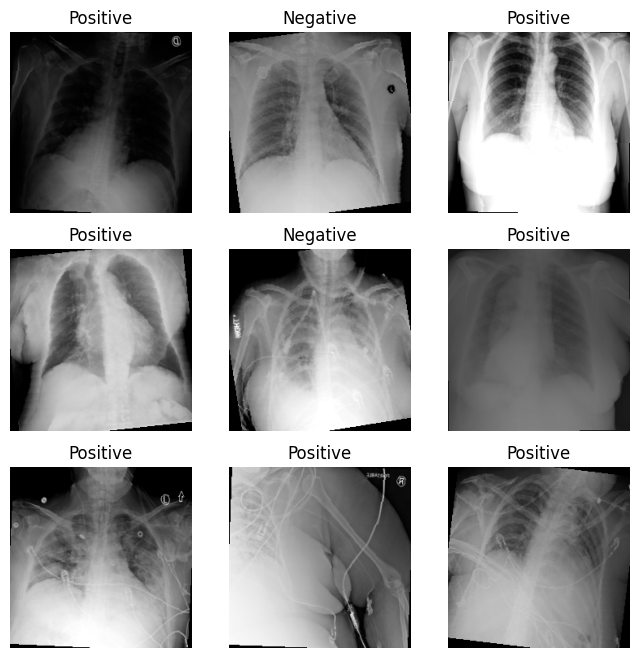

In [38]:
labels_map = {0: "Negative", 1: "Positive"}





#print specific indexes

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_imgs), size=(1,)).item()
    print(sample_idx)
    img, label = train_imgs[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    img = img.permute(1, 2, 0)
    img = img.numpy()
    plt.imshow(img)
plt.show()





In [39]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
training_acc = []
training_loss = []


def train_one_epoch(epoch_idx, tb_writer):
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #loss = criterion(outputs, labels.float().view(-1, 1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #preds = torch.round(outputs.detach().cpu())
        preds = torch.argmax(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        running_loss += loss
        
        if i % 10 == 9:
            last_loss = running_loss / 10
            print(f'Batch {i+1} Loss: {last_loss}')
            tb_x = epoch_idx * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train per batch', last_loss, tb_x)
            running_loss = 0.0
    
    print(f'Training accuracy: {accuracy_score(all_labels, all_preds)}')
    training_acc.append(accuracy_score(all_labels, all_preds))
    tb_writer.add_scalar('Accuracy/train', accuracy_score(all_labels, all_preds), epoch_idx+1)

    return last_loss   

In [ ]:
import time

tb_writer= SummaryWriter(f'runs/INSERTRUNNAMEHERE') 
epoch_number = 0
EPOCHS = 200
best_vloss = 1000000
best_MCC = -1
best_acc = 0


validation_loss = []
validation_acc = []

start_time = time.time()
print('Starting Training')
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    model.train()
    epoch_loss = train_one_epoch(epoch, tb_writer)
    training_loss.append(epoch_loss)

    running_vloss = 0.0
    all_labels = []
    all_preds = []
    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            #vloss = criterion(voutputs, vlabels.float().view(-1, 1))
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
            #preds = torch.round(voutputs.detach().cpu())
            preds = torch.argmax(voutputs, 1)
            all_labels.extend(vlabels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())


    avg_vloss = running_vloss / (i+1)
    validation_loss.append(avg_vloss)
    #mcc = matthews_corrcoef(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    validation_acc.append(acc)
    print(f'Training Loss: {epoch_loss} | Validation Loss {avg_vloss} | Validation Acc: {acc}')

    tb_writer.add_scalars('Training vs Validation Loss per Epoch',
                          {'Training' : epoch_loss, 'Validation' : avg_vloss},
                          epoch_number + 1)
    tb_writer.add_scalar('Validation ACC Per Epoch', acc, epoch_number+1)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        print('Saving model at epoch ', epoch_number+1, 'for loss')
        model_path = (f'{epoch_number+1}_INSERTMODELNAME_loss.pt')
        torch.save(model.state_dict(), model_path)

    if acc >= best_acc:
        best_acc = acc
        print('Saving model at epoch', epoch_number+1, 'for accuracy')
        model_path = (f'{epoch_number+1}_INSERTMODELNAME_acc.pt')
        torch.save(model.state_dict(), model_path)

    #save the last model on the last epoch
    if epoch_number == EPOCHS - 1:
        model_path = (f'{epoch_number+1}_INSERTMODELNAME_last.pt')
        print('Saving last model')
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1

end_time = time.time()
print('Finished Training')
print(f'Training took {end_time - start_time} seconds')

In [ ]:
#plot training and validation loss
training_loss_real = [x.item() for x in training_loss]
validation_loss_real = [x.item() for x in validation_loss]

#calculate the best validation loss and accuracy plot it on graph with the epoch number
best_val_loss = np.argmin(validation_loss_real)
best_val_acc = np.argmax(validation_acc)

plt.plot(training_loss_real, label='Training Loss')
plt.plot(validation_loss_real, label='Validation Loss')
plt.scatter(best_val_loss, validation_loss_real[best_val_loss], color='red', label='Best Validation Loss, epoch = ' + str(best_val_loss+1))
plt.title('Training vs Validation Loss for ResNet50 Adam-1e-4 BS128')
plt.legend()
plt.savefig('.//figs//training_vs_validation_loss_INSERTMODELNAME.png')
plt.show()


plt.plot(training_acc, label='Training Accuracy')
plt.plot(validation_acc, label='Validation Accuracy')
plt.scatter(best_val_acc, validation_acc[best_val_acc], color='red', label='Best Validation Accuracy, epoch = ' + str(best_val_acc+1))
plt.title('Training vs Validation Accuracy for ResNet50 Adam-1e-4 BS128')
plt.legend()
plt.savefig('.//figs//trainingvsvalidation_accuracy_INSERTMODELNAME.png')
plt.show()